In [1]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell
import numpy as np
import numpy.random as rng

In [3]:
import pandas.io.data as web
from pykalman import KalmanFilter
import numpy as np
import pandas as pd

In [4]:
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    #prices=np.asarray(list(prices))
    prices=prices.astype(float)
    return prices

In [5]:
gs = get_prices('GS')

In [6]:
def get_returns(prices):
    return (prices-prices.shift(-1))/prices

In [7]:
rets = get_returns(gs)*100

In [8]:
def sort_data(rets, N):
    ins = []
    outs = []
    for i in range(N):
        xx = np.random.randint(len(rets)-100)
        ins.append(rets[xx:xx+100].tolist())
        outs.append(rets[xx+100])
    return np.array(ins), np.array(outs)

In [9]:
ins, outs = sort_data(rets, 1000)


#TensorFlow 1

In [10]:
sess = tf.InteractiveSession()

In [11]:
x = tf.placeholder(tf.float32, [None, 100])
y_ = tf.placeholder(tf.float32, [None, 1])

In [12]:
# Parameters
learning_rate = 0.1
#training_epochs = 15
#batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 50 # 1st layer number of features
n_hidden_2 = 50 # 2nd layer number of features
n_input = 100 # MNIST data input (img shape: 28*28)
n_classes = 1 # MNIST total classes (0-9 digits)

In [13]:
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [14]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)


In [15]:
cost = tf.reduce_mean(tf.nn.l2_loss(pred - y_))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [16]:
init = tf.initialize_all_variables()

In [17]:
sess = tf.Session()
sess.run(init)

In [18]:
for epoch in range(2000):
    #batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(optimizer, feed_dict={x: ins, y_: outs.reshape(1,-1).T})
    if (epoch+1)%100== 0:
        c = sess.run(cost, feed_dict={x: ins, y_: outs.reshape(1,-1).T})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
            )

Epoch: 0100 cost= 42645.582031250
Epoch: 0200 cost= 8767.455078125
Epoch: 0300 cost= 2984.131103516
Epoch: 0400 cost= 1256.461914062
Epoch: 0500 cost= 569.345336914
Epoch: 0600 cost= 272.425781250
Epoch: 0700 cost= 122.141426086
Epoch: 0800 cost= 67.328788757
Epoch: 0900 cost= 39.963565826
Epoch: 1000 cost= 24.867198944
Epoch: 1100 cost= 16.242601395
Epoch: 1200 cost= 11.170567513
Epoch: 1300 cost= 8.165614128
Epoch: 1400 cost= 6.304071426
Epoch: 1500 cost= 5.108178616
Epoch: 1600 cost= 4.325002670
Epoch: 1700 cost= 3.804028034
Epoch: 1800 cost= 3.452492237
Epoch: 1900 cost= 3.210251570
Epoch: 2000 cost= 3.034924507


In [19]:
predict = pred

In [20]:
p = sess.run(predict, feed_dict={x: ins})

/Users/liamconnell/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


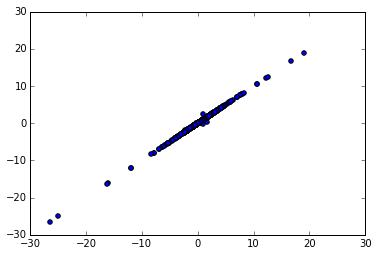

In [21]:
plt.scatter(p,outs)

In [22]:
new_ins, new_outs = sort_data(rets, 1000)

In [23]:
p = sess.run(predict, feed_dict={x: new_ins})

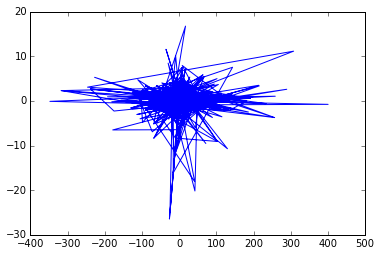

In [24]:
plot(p,new_outs)

In [25]:
from sklearn import linear_model

In [26]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(p,new_outs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(p) - new_outs) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(p, new_outs))

Coefficients: 
 [ 0.00054481]
Residual sum of squares: 8.59
Variance score: 0.00
